# Database inputs

1) https://www.reaxys.com/ <br>
2) Search structure below <br>
3) Set to widest similarity <br>
4) Set catalyst class -> active center -> Pd (10,425 reactions) <br>
5) Set single step only (6,731) <br>
6) Yield -> Exclude no value given (4418) <br>
7) Export data <br>
8) Run in Jupyter notebook

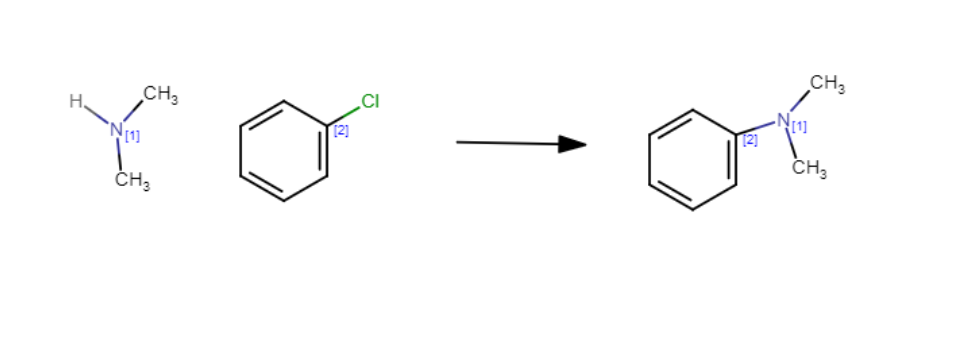

To do list:
- Cross validation, hyper parameter grid search
- Export csv of final dataframe and sense check it

Questions:
- Does it matter that the number of Morgan fingerprint inputs far outweigh one-hot coded reaction inputs (e.g. solvent, catalyst)? Does this overweight the reactants features too much?

- External reagents (catalyst, base) are currently one-hot coded but should they be converted to SMILES strings?

Further question:
- How to interpret results i.e. interpret best conditions for a given substrate

Low priority to do:
- Find instances where multiple columns are not null https://stackoverflow.com/questions/40408471/select-data-when-specific-columns-have-null-value-in-pandas e.g. when bases are combined, sometimes there are two bases

# Functions

In [1]:
def squeeze_nan(x):
    '''
    Takes dataframe x and gets rid of null by pushing all values:
    To the left (axis=1)
    To the top (axis=0)
    '''
    original_columns = x.index.tolist()
    squeezed = x.dropna()
    squeezed.index = [original_columns[n] for n in range(squeezed.count())]
    return squeezed.reindex(original_columns, fill_value=np.nan)

In [2]:
def clean_reactants(df, items_to_remove):
    '''
    Takes reactant column and removes unwanted molecules
    e.g. Halide and Group 1 counterions, bases
    '''
    m = df.isin(items_to_remove)
    df = df.mask(m)
    return df

# Data processing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
%load_ext pycodestyle_magic
%pycodestyle_on
sns.set_style("whitegrid")
pd.set_option('display.max_colwidth', None)

'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.constraints import max_norm
'''

'\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Activation, Dropout\nfrom tensorflow.keras.constraints import max_norm\n'

In [4]:
df = pd.read_csv('Reaxys_Buchwald_Hartwig.csv')

In [5]:
# Take only rows which have a yield
df = df[df['Yield (numerical)'].notna()]

# Remove yield entries with multiple yields separated by ;
df = df[~df['Yield (numerical)'].str.contains(';')]

len(df)

6611

In [6]:
# Sort yield in descending order
df = df.sort_values(by=['Yield (numerical)'], ascending=False)
df['Yield'] = df['Yield (numerical)']

## Reactants and Products

In [7]:
# Cleaning reactants and products

# Take only rows which have a reactant/product
df = df[df['Reaction'].notna()]

# Split into reactants and products
df['Reactant smiles'] = df['Reaction'].str.split('>>', expand=True)[0]
df['P_smiles'] = df['Reaction'].str.split('>>', expand=True)[1]

In [8]:
# Splitting reactants into individual components
reactants = df['Reactant smiles'].str.split('.', expand=True)
reactants = reactants.fillna(value=np.nan)
reactants.columns = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7']

In [9]:
# Molecules to remove from reactants columns
items = ['Cl', 'Br', 'I', '[Na+]', 'CC(C)(C)[O-]', 'CCC(C)(C)[O-]',
         'OC(=O)C(F)(F)F']
"""
In very few cases the base is only included here and not in reagents,
but this is <10 examples
"""

'\nIn very few cases the base is only included here and not in reagents,\nbut this is <10 examples\n'

In [10]:
# Remove items from reactants
reactants['r1'] = clean_reactants(reactants['r1'], items)
reactants['r2'] = clean_reactants(reactants['r2'], items)
reactants['r3'] = clean_reactants(reactants['r3'], items)
reactants['r4'] = clean_reactants(reactants['r4'], items)
reactants['r5'] = clean_reactants(reactants['r5'], items)
reactants['r6'] = clean_reactants(reactants['r6'], items)
reactants['r7'] = clean_reactants(reactants['r7'], items)

In [11]:
# Remove reactant null values
reactants = reactants.apply(squeeze_nan, axis=1)

## Reagents and Catalysts

In [12]:
# Splitting reagents into indiviudal components
reagents = df['Reagent'].str.split(';', expand=True)
reagents = reagents.fillna(value=np.nan)

In [13]:
# Splitting catalyst into individual components
catalysts = df['Catalyst'].str.split(';', expand=True)
catalysts = catalysts.fillna(value=np.nan)

In [14]:
# Combining reagent and catalyst columns
combined_reagents = pd.concat([reagents, catalysts], axis=1)
combined_reagents.columns = ['a1', 'a2', 'a3', 'a4', 'a5',
                             'a6', 'a7', 'a8', 'a9', 'a10']

In [15]:
# Squeeze all reagents together
combined_reagents = combined_reagents.apply(squeeze_nan, axis=1)

In [16]:
combined_reagents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6586 entries, 672 to 7320
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      6547 non-null   object 
 1   a2      6174 non-null   object 
 2   a3      5125 non-null   object 
 3   a4      311 non-null    object 
 4   a5      40 non-null     object 
 5   a6      7 non-null      object 
 6   a7      5 non-null      object 
 7   a8      0 non-null      float64
 8   a9      0 non-null      float64
 9   a10     0 non-null      float64
dtypes: float64(3), object(7)
memory usage: 566.0+ KB


In [17]:
# Drop excess columns
combined_reagents = combined_reagents.drop(['a8', 'a9', 'a10'], axis=1)

## Solvent

In [18]:
# Change multi solvent to single solvent
df['Solvent'] = df['Solvent (Reaction Details)'].str.split(';', expand=True)[0]
df['Solvent'] = df['Solvent'].str.title()

## New dataframe

In [19]:
# Make new clean dataframe
clean_df = df[['Reaction ID', 'P_smiles', 'Solvent',
               'Yield', 'References', 'Reagent']]

# Add reactants and reagents
clean_df = pd.concat([clean_df, reactants, combined_reagents], axis=1)

In [20]:
# Remove cases where there is no reagent component 1 or 2
clean_df = clean_df[clean_df['a1'].notna()]
clean_df = clean_df[clean_df['a2'].notna()]

# Remove cases where there are more than 2 reactants
clean_df = clean_df[clean_df['r3'].isna()]
clean_df = clean_df[clean_df['r4'].isna()]
clean_df = clean_df[clean_df['r5'].isna()]
clean_df = clean_df[clean_df['r6'].isna()]
clean_df = clean_df[clean_df['r7'].isna()]

# Remove cases where there is only 1 reactant
clean_df = clean_df[clean_df['r2'].notna()]
clean_df = clean_df.drop(['r3', 'r4', 'r5', 'r6', 'r7'], axis=1)

# Rename reactants 1 and 2
clean_df = clean_df.rename(columns={'r1': 'R1_smiles', 'r2': 'R2_smiles'})

# Remove cases where there is no solvent
clean_df = clean_df[clean_df['Solvent'].notna()]

# Change yield to float
clean_df['Yield'] = clean_df['Yield'].astype(float)

In [21]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5687 entries, 2810 to 3510
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Reaction ID  5687 non-null   object 
 1   P_smiles     5687 non-null   object 
 2   Solvent      5687 non-null   object 
 3   Yield        5687 non-null   float64
 4   References   5687 non-null   object 
 5   Reagent      5677 non-null   object 
 6   R1_smiles    5687 non-null   object 
 7   R2_smiles    5687 non-null   object 
 8   a1           5687 non-null   object 
 9   a2           5687 non-null   object 
 10  a3           4729 non-null   object 
 11  a4           267 non-null    object 
 12  a5           40 non-null     object 
 13  a6           7 non-null      object 
 14  a7           5 non-null      object 
dtypes: float64(1), object(14)
memory usage: 710.9+ KB


## Catalyst

In [22]:
test_catalyst = ['\\[Pd']
test_catalyst = '|'.join(test_catalyst)
clean_df[clean_df['a1'].str.contains(test_catalyst, na=False)]['a1'].count()

66

In [23]:
# Catalysts to screen
catalyst = ['palladium', 'Pd', '\\[Pd', 'palladacycle']
catalyst = '|'.join(catalyst)

In [24]:
# Extract catalysts
clean_df['Catalyst_a1'] = clean_df[clean_df['a1'].str.contains(catalyst,
                                                               na=False)]['a1']
clean_df['Catalyst_a2'] = clean_df[clean_df['a2'].str.contains(catalyst,
                                                               na=False)]['a2']
clean_df['Catalyst_a3'] = clean_df[clean_df['a3'].str.contains(catalyst,
                                                               na=False)]['a3']
clean_df['Catalyst_a4'] = clean_df[clean_df['a4'].str.contains(catalyst,
                                                               na=False)]['a4']
clean_df['Catalyst_a5'] = clean_df[clean_df['a5'].str.contains(catalyst,
                                                               na=False)]['a5']
clean_df['Catalyst_a6'] = clean_df[clean_df['a6'].str.contains(catalyst,
                                                               na=False)]['a6']
clean_df['Catalyst_a7'] = clean_df[clean_df['a7'].str.contains(catalyst,
                                                               na=False)]['a7']

clean_df['Catalyst_a1'] = clean_df['Catalyst_a1'].str.strip().fillna('')
clean_df['Catalyst_a2'] = clean_df['Catalyst_a2'].str.strip().fillna('')
clean_df['Catalyst_a3'] = clean_df['Catalyst_a3'].str.strip().fillna('')
clean_df['Catalyst_a4'] = clean_df['Catalyst_a4'].str.strip().fillna('')
clean_df['Catalyst_a5'] = clean_df['Catalyst_a5'].str.strip().fillna('')
clean_df['Catalyst_a6'] = clean_df['Catalyst_a6'].str.strip().fillna('')
clean_df['Catalyst_a7'] = clean_df['Catalyst_a7'].str.strip().fillna('')

In [25]:
# Make catalyst column that combines the ligands
clean_df['Catalyst'] = clean_df[['Catalyst_a1',
                                 'Catalyst_a2',
                                 'Catalyst_a3',
                                 'Catalyst_a4',
                                 'Catalyst_a5',
                                 'Catalyst_a6',
                                 'Catalyst_a7']].sum(axis=1)

In [26]:
# Rename catalysts

clean_df['Catalyst'].replace("tris-(dibenzylideneacetone)dipalladium(0)",
                             'Pd2(dba)3', inplace=True)
clean_df['Catalyst'].replace("palladium diacetate",
                             'Pd(OAc)2', inplace=True)
clean_df['Catalyst'].replace("tris(dibenzylideneacetone)dipalladium (0)",
                             'Pd2(dba)3', inplace=True)
clean_df['Catalyst'].replace("bis(dibenzylideneacetone)-palladium(0)",
                             'Pd(dba)2', inplace=True)

In [27]:
# Check empty catalysts and remove
# clean_df[clean_df['Catalyst']=='']['Reagent'].tail(20)

clean_df['Catalyst'].replace('', np.nan, inplace=True)
clean_df = clean_df[clean_df['Catalyst'].notna()]

## Ligand

In [28]:
# Ligands to screen
ligand = ['phos', 'Phos', '2-P\\(t-Bu\\)2-biphenyl']
ligand = '|'.join(ligand)

In [29]:
# Extract ligands
clean_df['Ligand_a1'] = clean_df[clean_df['a1'].str.contains(ligand,
                                                             na=False)]['a1']
clean_df['Ligand_a2'] = clean_df[clean_df['a2'].str.contains(ligand,
                                                             na=False)]['a2']
clean_df['Ligand_a3'] = clean_df[clean_df['a3'].str.contains(ligand,
                                                             na=False)]['a3']
clean_df['Ligand_a4'] = clean_df[clean_df['a4'].str.contains(ligand,
                                                             na=False)]['a4']
clean_df['Ligand_a5'] = clean_df[clean_df['a5'].str.contains(ligand,
                                                             na=False)]['a5']
clean_df['Ligand_a6'] = clean_df[clean_df['a6'].str.contains(ligand,
                                                             na=False)]['a6']
clean_df['Ligand_a7'] = clean_df[clean_df['a7'].str.contains(ligand,
                                                             na=False)]['a7']

clean_df['Ligand_a1'] = clean_df['Ligand_a1'].str.strip().fillna('')
clean_df['Ligand_a2'] = clean_df['Ligand_a2'].str.strip().fillna('')
clean_df['Ligand_a3'] = clean_df['Ligand_a3'].str.strip().fillna('')
clean_df['Ligand_a4'] = clean_df['Ligand_a4'].str.strip().fillna('')
clean_df['Ligand_a5'] = clean_df['Ligand_a5'].str.strip().fillna('')
clean_df['Ligand_a6'] = clean_df['Ligand_a6'].str.strip().fillna('')
clean_df['Ligand_a7'] = clean_df['Ligand_a7'].str.strip().fillna('')

clean_df['Ligand_a1'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a2'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a3'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a4'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a5'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a6'].replace('potassium phosphate', '',
                              inplace=True)
clean_df['Ligand_a7'].replace('potassium phosphate', '',
                              inplace=True)

In [30]:
# Make ligand column that combines the ligands
clean_df['Ligand'] = clean_df[['Ligand_a1',
                               'Ligand_a2',
                               'Ligand_a3',
                               'Ligand_a4',
                               'Ligand_a5',
                               'Ligand_a6',
                               'Ligand_a7']].sum(axis=1)

# Xantphos has a broken name for some reason
clean_df['Ligand'].replace('4,5-bis(diphenylphos4,5-bis(diphenylphosphino)-9,9-dimethylxanthenephino)-9,9-dimethylxanthene',
                           'Xantphos', inplace=True)

clean_df['Ligand'].replace("2,2'-bis-(diphenylphosphino)-1,1'-binaphthyl",
                           'BINAP', inplace=True)
clean_df['Ligand'].replace('', 'None', inplace=True)
clean_df['Ligand'] = clean_df['Ligand'].str.title()

11:80: E501 line too long (124 > 79 characters)


In [31]:
# Check empties. Do not remove, since ligand might be part of catalyst
# clean_df[clean_df['Ligand']=='']['Reagent'].head(60)

Seem to be missing 15% of ligands. Mostly where a Pd precatalyst is used.

## Base

In [32]:
# Bases to screen
base = ['butanolate', 'butylate', 'carbonate', 'Quinuclidine',
        'potassium phosphate', 'hexamethyldisilazane',
        'hydride', 'NaO-t-Pent', 'tert-butoxide',
        'phenol sodium salt', '2-methylbutan-2-olate',
        'tert-pentoxide', 'isopentoxide',
        'pentamethylchroman-6-ol potassium salt',
        'n-propoxide', 'diisopropyl amide',
        'sodium isopropylate', 'sodium pivalate', 'tributyl-amine']
base = '|'.join(base)

In [33]:
# Extract bases
clean_df['Base_a1'] = clean_df[clean_df['a1'].str.contains(base,
                                                           na=False)]['a1']
clean_df['Base_a2'] = clean_df[clean_df['a2'].str.contains(base,
                                                           na=False)]['a2']
clean_df['Base_a3'] = clean_df[clean_df['a3'].str.contains(base,
                                                           na=False)]['a3']
clean_df['Base_a4'] = clean_df[clean_df['a4'].str.contains(base,
                                                           na=False)]['a4']
clean_df['Base_a5'] = clean_df[clean_df['a5'].str.contains(base,
                                                           na=False)]['a5']
clean_df['Base_a6'] = clean_df[clean_df['a6'].str.contains(base,
                                                           na=False)]['a6']
clean_df['Base_a7'] = clean_df[clean_df['a7'].str.contains(base,
                                                           na=False)]['a7']

clean_df['Base_a1'] = clean_df['Base_a1'].str.strip().fillna('')
clean_df['Base_a2'] = clean_df['Base_a2'].str.strip().fillna('')
clean_df['Base_a3'] = clean_df['Base_a3'].str.strip().fillna('')
clean_df['Base_a4'] = clean_df['Base_a4'].str.strip().fillna('')
clean_df['Base_a5'] = clean_df['Base_a5'].str.strip().fillna('')
clean_df['Base_a6'] = clean_df['Base_a6'].str.strip().fillna('')
clean_df['Base_a7'] = clean_df['Base_a7'].str.strip().fillna('')

In [34]:
# Make base column that combines the bases
clean_df['Base'] = clean_df[['Base_a1',
                             'Base_a2',
                             'Base_a3',
                             'Base_a4',
                             'Base_a5',
                             'Base_a6',
                             'Base_a7']].sum(axis=1)

clean_df['Base'] = clean_df['Base'].str.title()
clean_df['Base'].replace('Nao-T-Pent', 'Sodium Tert-Pentoxide', inplace=True)

In [35]:
# Check empty bases and remove
# clean_df[clean_df['Base']=='None']['Reagent'].head(60)

clean_df['Base'].replace('', np.nan, inplace=True)
clean_df = clean_df[clean_df['Base'].notna()]

# Final cleaning

In [36]:
final_df = clean_df[['R1_smiles',
                     'R2_smiles',
                     'P_smiles',
                     'Solvent',
                     'Catalyst',
                     'Ligand',
                     'Base',
                     'Yield']]

In [37]:
final_df = final_df[~final_df['R1_smiles'].str.contains('CCCCCC1=C2C=C3C')]
'''
RDKit does not like Zn coordinated complex
CCCCCC1=C2C=C3C(CCCCC)=C(C)C4=[N]3[Zn++]35[N-]2C(C=C2C(C)=C(C)C(C(=C6[N-]3C(=C4)C(C)=C6C)C3=CC=C(Br)C=C3)=[N]52)=C1C
Had to manually remove it
'''

'\nRDKit does not like Zn coordinated complex\nCCCCCC1=C2C=C3C(CCCCC)=C(C)C4=[N]3[Zn++]35[N-]2C(C=C2C(C)=C(C)C(C(=C6[N-]3C(=C4)C(C)=C6C)C3=CC=C(Br)C=C3)=[N]52)=C1C\nHad to manually remove it\n'

In [38]:
# Drop exact duplicates
final_df = final_df.drop_duplicates(keep='first')

# Re-index
final_df = final_df.reset_index(drop=True)

# EDA

Text(0.5, 0, 'Percentage')

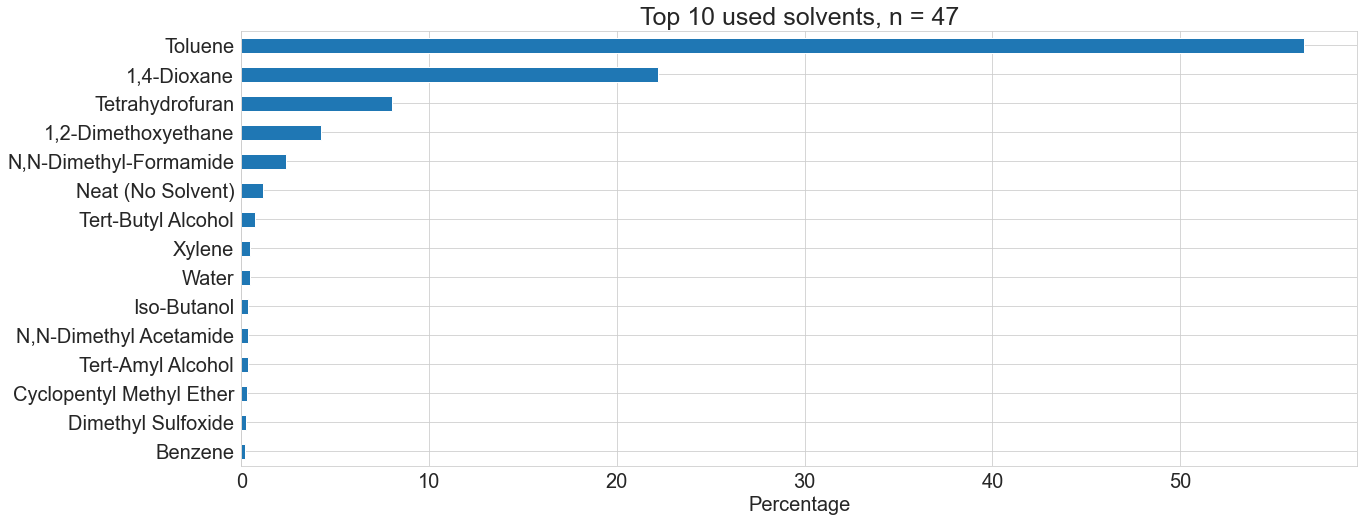

In [39]:
solvent_count = final_df['Solvent'].value_counts().count()

plt.figure(figsize=(20, 8))
solvent_percent = final_df['Solvent'].value_counts(normalize=True)*100
ax = solvent_percent.nlargest(15).plot(kind='barh')
plt.title(f'Top 10 used solvents, n = {solvent_count}', size=25)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.invert_yaxis()
plt.xlabel('Percentage', size=20)

Text(0.5, 0, 'Percentage')

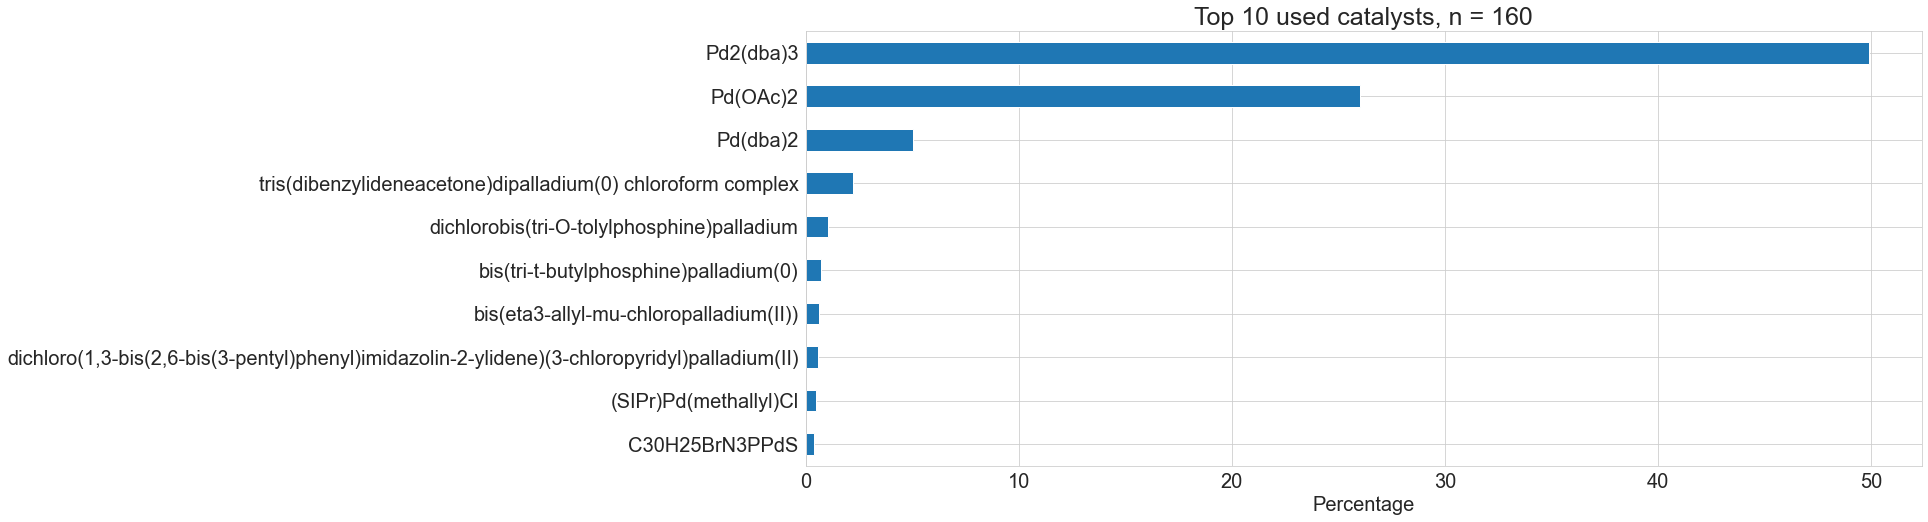

In [40]:
catalyst_count = final_df['Catalyst'].value_counts().count()

plt.figure(figsize=(20, 8))
catalyst_percent = final_df['Catalyst'].value_counts(normalize=True)*100
ax = catalyst_percent.nlargest(10).plot(kind='barh')
plt.title(f'Top 10 used catalysts, n = {catalyst_count}', size=25)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.invert_yaxis()
plt.xlabel('Percentage', size=20)

Text(0.5, 0, 'Percentage')

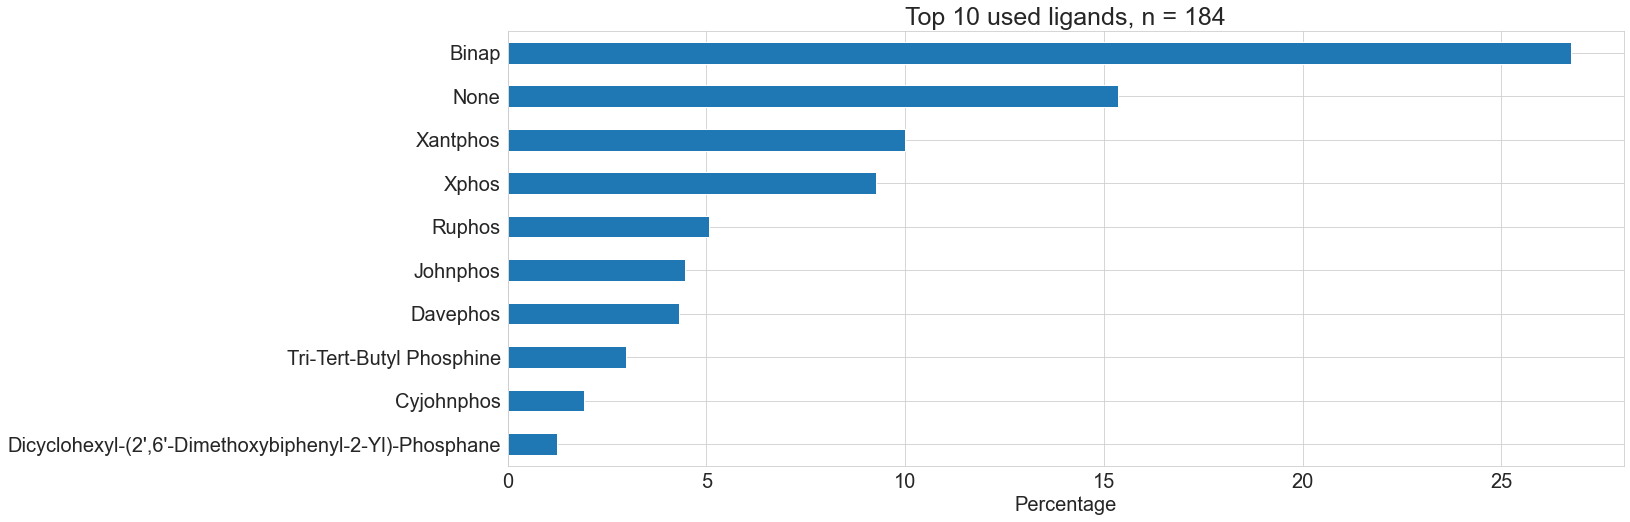

In [41]:
ligand_count = final_df['Ligand'].value_counts().count()

plt.figure(figsize=(20, 8))
ligand_percent = final_df['Ligand'].value_counts(normalize=True)*100
ax = ligand_percent.nlargest(10).plot(kind='barh')
plt.title(f'Top 10 used ligands, n = {ligand_count}', size=25)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.invert_yaxis()
plt.xlabel('Percentage', size=20)

Text(0.5, 0, 'Percentage')

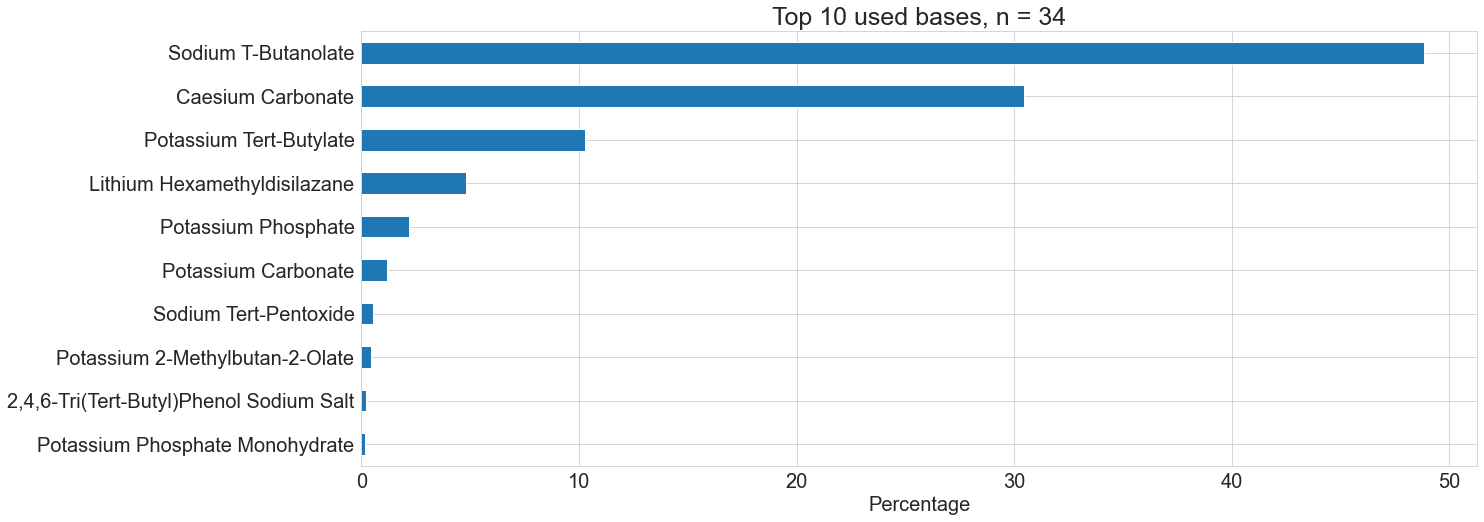

In [42]:
base_count = final_df['Base'].value_counts().count()

plt.figure(figsize=(20, 8))
base_percent = final_df['Base'].value_counts(normalize=True)*100
ax = base_percent.nlargest(10).plot(kind='barh')
plt.title(f'Top 10 used bases, n = {base_count}', size=25)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.invert_yaxis()
plt.xlabel('Percentage', size=20)

Text(0.5, 0, 'Yield')

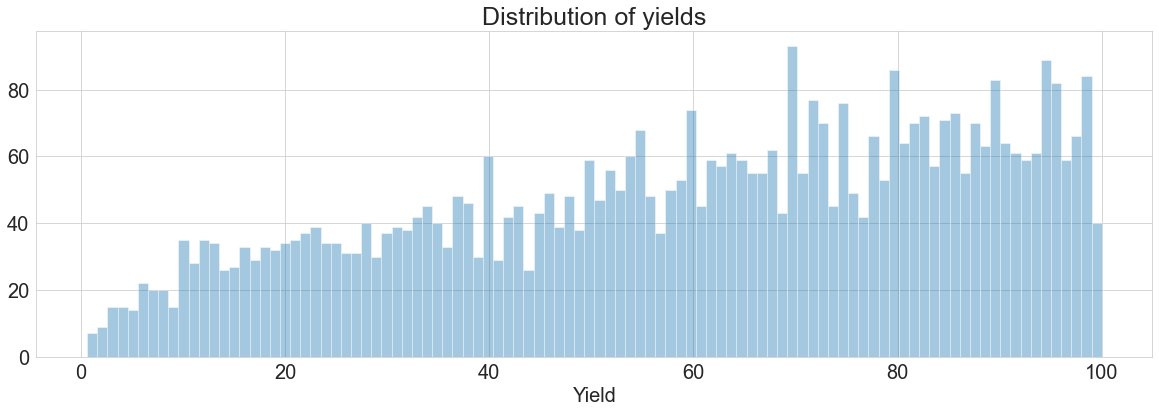

In [43]:
plt.figure(figsize=(20, 6))
ax = sns.distplot(final_df['Yield'], kde=False, bins=100)
plt.title('Distribution of yields', size=25)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
plt.xlabel('Yield', size=20)

In [44]:
# Attempting to separate amine and electrophile which are distributed randomly in r1 and r2

# Assume electrophile must contain the halide
halides = ['Cl', 'Br', 'I']
halides = '|'.join(halides)

reactant_df = final_df.copy()
reactant_df['Amine_r1'] = reactant_df[~reactant_df['R1_smiles'].str.contains(halides)]['R1_smiles']
reactant_df['Electrophile_r1'] = reactant_df[reactant_df['R1_smiles'].str.contains(halides)]['R1_smiles']

reactant_df['Amine_r2'] = reactant_df[~reactant_df['R2_smiles'].str.contains(halides)]['R2_smiles']
reactant_df['Electrophile_r2'] = reactant_df[reactant_df['R2_smiles'].str.contains(halides)]['R2_smiles']

1:80: E501 line too long (91 > 79 characters)
8:80: E501 line too long (99 > 79 characters)
9:80: E501 line too long (105 > 79 characters)
11:80: E501 line too long (99 > 79 characters)
12:80: E501 line too long (105 > 79 characters)


In [45]:
reactant_df.drop(['R1_smiles', 'R2_smiles', 'P_smiles', 'Solvent',
                  'Catalyst', 'Ligand','Base', 'Yield'],
                axis=1, inplace=True)

2:39: E231 missing whitespace after ','
3:17: E128 continuation line under-indented for visual indent


In [46]:
reactant_df = reactant_df[['Amine_r1', 'Amine_r2', 'Electrophile_r1', 'Electrophile_r2']]

1:80: E501 line too long (89 > 79 characters)


In [47]:
reactant_df = reactant_df.apply(squeeze_nan, axis=1)

In [48]:
reactant_df.drop(['Electrophile_r1', 'Electrophile_r2'], axis=1, inplace=True)

In [49]:
reactant_df.columns = ['Amine', 'Electrophile']

In [50]:
reactant_df['Amine'].value_counts(normalize=True)*100

C1COCCN1                                                            22.712007
CC(C)(C)OC(=O)N1CCNCC1                                               7.430730
CN1CCNCC1                                                            5.352645
C1CCNCC1                                                             5.016793
C1CCNC1                                                              3.946264
                                                                      ...    
[H][C@]12CC[C@]([H])(C[C@@H](C1)OC1=NC(=CC(=O)N1C)C1=NC=NC=C1)N2     0.020991
FC(F)(F)[C@@H]1CNCCO1                                                0.020991
CNCC1=CC=C(OC)C=C1                                                   0.020991
FC(F)(F)C1=CC=C(CN2CCNCC2C2=CC=CC=C2)C=N1                            0.020991
CC1NCCC2=C1C=CC=C2                                                   0.020991
Name: Amine, Length: 935, dtype: float64

In [51]:
reactant_df['Electrophile'].value_counts(normalize=True)*100

BrC1=CC=CC=C1                                                        2.644836
CC1=CC=C(Cl)C=C1                                                     2.455919
COC1=CC=C(Br)C=C1                                                    1.931150
COC1=CC=C(Cl)C=C1                                                    1.847187
CC1=CC=C(Br)C=C1                                                     1.805206
                                                                       ...   
C[C@H](O[Si](C)(C)C(C)(C)C)C1=NC=CN1CC1=NOC(=C1)C#CC1=CC=C(I)C=C1    0.020991
COC1=C(C(=O)OC2=CC=CC=C2)C(C)=C(I)C(Br)=C1                           0.020991
FC1=CC2=C(C=C1Br)N(C1CC1)C(=O)C1=NC=NN21                             0.020991
CN1CCC[C@H](C1)OC1=C(Br)C=CC=C1                                      0.020991
CC1=CC2=CC(Br)=CC=C2N1                                               0.020991
Name: Electrophile, Length: 1990, dtype: float64

In [52]:
reactant_df

,Amine,Electrophile
0,C[C@H]1CNC[C@@H](C)N1,CC(C)(C)OC(=O)N1CCC2=C(C1)C=CC(Br)=C2
1,COCCNCCOC,CC(C)(C)OC(=O)N1CCOC2=C(C1)C=CC(Br)=C2
2,FC(F)(F)[C@@H]1CCCN1,COC1=CC=C(Cl)C=C1
3,C1COCCN1,IC1=CC=CC=C1
4,C1COCCN1,COC1=CC=CC(Cl)=C1
...,...,...
4759,O=S(=O)(N1CCN[C@@H](CC2CCOCC2)C1)C1=CC=CS1,C[C@@](O)(C1=CC=C(Br)C=C1)C(F)(F)F
4760,CC(C)[C@H]1CN(CCN1)S(=O)(=O)C1=CC=CS1,OC(C1=CC=C(Br)C=C1)(C(F)(F)F)C(F)(F)F
4761,COC1=CC2=C(NC(=O)N(CC2)C2CCNCC2)C=C1,CN1C(=O)OC2=C1C(C)=CC(=C2)C(=O)C1=CC(Br)=CC=C1
4762,C1CN2N=C(N=C2CN1)C1=NC=CC=C1,FC1=CC(=CC(Br)=C1)C#N


In [53]:



'''
MolsToGridImage(mols=mol_list, subImgSize=(1000, 1000),
                molsPerRow=4, maxMols=100)
'''

'\nMolsToGridImage(mols=mol_list, subImgSize=(1000, 1000),\n                molsPerRow=4, maxMols=100)\n'

4:1: E303 too many blank lines (3)


# One-hot featurization

In [54]:
one_hot_df = reactant_df.copy()

In [55]:
one_hot_df[['Product','Catalyst', 'Ligand', 'Base', 'Solvent', 'Yield']] = final_df[['P_smiles', 'Catalyst', 'Ligand', 'Base', 'Solvent', 'Yield']]

1:22: E231 missing whitespace after ','
1:80: E501 line too long (147 > 79 characters)


In [56]:
# Create dummy variables
solvent_dummies = pd.get_dummies(one_hot_df['Solvent'])
catalyst_dummies = pd.get_dummies(one_hot_df['Catalyst'])
ligand_dummies = pd.get_dummies(one_hot_df['Ligand'])
base_dummies = pd.get_dummies(one_hot_df['Base'])

one_hot_df = pd.concat([one_hot_df.drop('Solvent', axis=1),
                        solvent_dummies], axis=1)
one_hot_df = pd.concat([one_hot_df.drop('Catalyst', axis=1),
                        catalyst_dummies], axis=1)
one_hot_df = pd.concat([one_hot_df.drop('Ligand', axis=1),
                        ligand_dummies], axis=1)
one_hot_df = pd.concat([one_hot_df.drop('Base', axis=1),
                        base_dummies], axis=1)

In [57]:
one_hot_df.shape

(4764, 429)

# Featurization

In [58]:
feat_df = reactant_df.copy()
feat_df[['Product','Catalyst', 'Ligand', 'Base', 'Solvent', 'Yield']] = final_df[['P_smiles', 'Catalyst', 'Ligand', 'Base', 'Solvent', 'Yield']]

2:19: E231 missing whitespace after ','
2:80: E501 line too long (144 > 79 characters)


In [59]:
# Create dummy variables
solvent_dummies = pd.get_dummies(feat_df['Solvent'])
catalyst_dummies = pd.get_dummies(feat_df['Catalyst'])
ligand_dummies = pd.get_dummies(feat_df['Ligand'])
base_dummies = pd.get_dummies(feat_df['Base'])

In [60]:
# Concat and drop
feat_df = pd.concat([feat_df.drop('Solvent', axis=1),
                    solvent_dummies], axis=1)
feat_df = pd.concat([feat_df.drop('Catalyst', axis=1),
                    catalyst_dummies], axis=1)
feat_df = pd.concat([feat_df.drop('Ligand', axis=1),
                    ligand_dummies], axis=1)
feat_df = pd.concat([feat_df.drop('Base', axis=1),
                    base_dummies], axis=1)

In [61]:
feat_df.shape

(4764, 429)

In [62]:
# Prepare molecules for featurization
amine_mol = [Chem.MolFromSmiles(smiles) for smiles in feat_df['Amine']]

electrophile_mol = [Chem.MolFromSmiles(smiles) for smiles in feat_df['Electrophile']]

product_mol = [Chem.MolFromSmiles(smiles) for smiles in feat_df['Product']]

4:80: E501 line too long (85 > 79 characters)


In [63]:
def generate_morgan(mol_list):

    mol_morgan = np.array([])

    for molecule in mol_list:
        
        Morgan3 = Chem.GetMorganFingerprintAsBitVect(molecule, 3).ToBitString()
        Morgan3arr = np.array(list(map(int, Morgan3)))
        
        if len(mol_morgan) == 0:
            mol_morgan = Morgan3arr
        else:
            mol_morgan = np.vstack((mol_morgan, Morgan3arr))
            
    return mol_morgan

6:1: W293 blank line contains whitespace
9:1: W293 blank line contains whitespace
14:1: W293 blank line contains whitespace


In [64]:
amine_morgan = generate_morgan(amine_mol)

In [65]:
electrophile_morgan = generate_morgan(electrophile_mol)
product_morgan = generate_morgan(product_mol)

In [66]:
amine_morgan_df = pd.DataFrame(amine_morgan)
electrophile_morgan_df = pd.DataFrame(electrophile_morgan)
product_morgan_df = pd.DataFrame(product_morgan)

In [67]:
'''

# Generate Morgan fingerprints

amine_morgan = np.array([])
# r1_error = np.array([])

for molecule in r1_mol:
    # if molecule is None:
    # r1_error = molecule
    # continue
    Morgan3 = Chem.GetMorganFingerprintAsBitVect(molecule, 3).ToBitString()
    Morgan3arr = np.array(list(map(int, Morgan3)))
    if len(r1_morgan) == 0:
        r1_morgan = Morgan3arr
    else:
        r1_morgan = np.vstack((r1_morgan, Morgan3arr))


r2_morgan = np.array([])
for molecule in r2_mol:
    Morgan3 = Chem.GetMorganFingerprintAsBitVect(molecule, 3).ToBitString()
    Morgan3arr = np.array(list(map(int, Morgan3)))
    if len(r2_morgan) == 0:
        r2_morgan = Morgan3arr
    else:
        r2_morgan = np.vstack((r2_morgan, Morgan3arr))
        
        '''

'\n\n# Generate Morgan fingerprints\n\namine_morgan = np.array([])\n# r1_error = np.array([])\n\nfor molecule in r1_mol:\n    # if molecule is None:\n    # r1_error = molecule\n    # continue\n    Morgan3 = Chem.GetMorganFingerprintAsBitVect(molecule, 3).ToBitString()\n    Morgan3arr = np.array(list(map(int, Morgan3)))\n    if len(r1_morgan) == 0:\n        r1_morgan = Morgan3arr\n    else:\n        r1_morgan = np.vstack((r1_morgan, Morgan3arr))\n\n\nr2_morgan = np.array([])\nfor molecule in r2_mol:\n    Morgan3 = Chem.GetMorganFingerprintAsBitVect(molecule, 3).ToBitString()\n    Morgan3arr = np.array(list(map(int, Morgan3)))\n    if len(r2_morgan) == 0:\n        r2_morgan = Morgan3arr\n    else:\n        r2_morgan = np.vstack((r2_morgan, Morgan3arr))\n        \n        '

28:1: W293 blank line contains whitespace


In [72]:
feat_df

,Amine,Electrophile,Product,Yield,(2)H8-Toluene,"1,1-Dichloroethane","1,2-Dichloro-Ethane","1,2-Dimethoxyethane","1,3-Dioxane","1,4-Dioxane",...,Sodium Isopropylate,Sodium N-Propoxide,Sodium Pivalate,Sodium T-Butanolate,Sodium T-Butanolatesodium Hydrogencarbonate,Sodium T-Butanolatesodium T-Butanolate,Sodium Tert-Pentoxide,Sodium Tris(Acetoxy)Borohydride,Tributyl-Amine,Tributyl-Aminesodium T-Butanolate
0,C[C@H]1CNC[C@@H](C)N1,CC(C)(C)OC(=O)N1CCC2=C(C1)C=CC(Br)=C2,C[C@H]1CN(C[C@@H](C)N1)C1=CC2=C(CN(CC2)C(=O)OC(C)(C)C)C=C1,99.69,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,COCCNCCOC,CC(C)(C)OC(=O)N1CCOC2=C(C1)C=CC(Br)=C2,COCCN(CCOC)C1=CC2=C(CN(CCO2)C(=O)OC(C)(C)C)C=C1,99.10,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,FC(F)(F)[C@@H]1CCCN1,COC1=CC=C(Cl)C=C1,COC1=CC=C(C=C1)N1CCC[C@H]1C(F)(F)F,99.00,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,C1COCCN1,IC1=CC=CC=C1,C1CN(CCO1)C1=CC=CC=C1,99.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,C1COCCN1,COC1=CC=CC(Cl)=C1,COC1=CC(=CC=C1)N1CCOCC1,99.00,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,O=S(=O)(N1CCN[C@@H](CC2CCOCC2)C1)C1=CC=CS1,C[C@@](O)(C1=CC=C(Br)C=C1)C(F)(F)F,C[C@@](O)(C1=CC=C(C=C1)N1CCN(C[C@@H]1CC1CCOCC1)S(=O)(=O)C1=CC=CS1)C(F)(F)F,1.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4760,CC(C)[C@H]1CN(CCN1)S(=O)(=O)C1=CC=CS1,OC(C1=CC=C(Br)C=C1)(C(F)(F)F)C(F)(F)F,CC(C)[C@H]1CN(CCN1C1=CC=C(C=C1)C(O)(C(F)(F)F)C(F)(F)F)S(=O)(=O)C1=CC=CS1,1.00,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4761,COC1=CC2=C(NC(=O)N(CC2)C2CCNCC2)C=C1,CN1C(=O)OC2=C1C(C)=CC(=C2)C(=O)C1=CC(Br)=CC=C1,COC1=CC2=C(NC(=O)N(CC2)C2CCN(CC2)C2=CC(=CC=C2)C(=O)C2=CC3=C(N(C)C(=O)O3)C(C)=C2)C=C1,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4762,C1CN2N=C(N=C2CN1)C1=NC=CC=C1,FC1=CC(=CC(Br)=C1)C#N,FC1=CC(=CC(=C1)N1CCN2N=C(N=C2C1)C1=NC=CC=C1)C#N,0.60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Drop smiles and append Morgan fingerprints
dropped_feat_df = feat_df.drop(['Amine', 'Electrophile', 'Product'], axis=1)
input_df = pd.concat([dropped_feat_df, amine_morgan_df, electrophile_morgan_df], axis=1)

input_df.head(1)

,Yield,(2)H8-Toluene,"1,1-Dichloroethane","1,2-Dichloro-Ethane","1,2-Dimethoxyethane","1,3-Dioxane","1,4-Dioxane",1-Methyl-Pyrrolidin-2-One,1-Methylpiperidin-2-One,2-Methyl-Propan-1-Ol,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,99.69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


3:80: E501 line too long (88 > 79 characters)


# Machine Learning

In [70]:
X1 = one_hot_df.drop('Yield', axis=1).values
y1 = one_hot_df['Yield'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                        y1,
                                                        test_size=0.20,
                                                        random_state=101)

In [71]:
regr1 = RandomForestRegressor(max_depth=15, random_state=0)
regr1.fit(X1_train, y1_train)

ValueError: could not convert string to float: 'C1COCCN1'

In [ ]:
y1_pred_initial = regr1.predict(X1_train)

y1_pred_initial_mae = mean_absolute_error(y1_train, y1_pred_initial)
textstr = 'Mean absolute error = '+str(round(y1_pred_initial_mae))

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.scatter(y1_train, y1_pred_initial)
plt.xlabel('True yield', size=20)
plt.ylabel('Predicted yield', size=20)
plt.title('Random forest regressor on original training data, one hot encoded', size=20)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.95, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', bbox=props)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
true_points = np.arange(1, 101)
plt.plot(true_points, true_points, linestyle='--', color='k', lw=3)

In [ ]:
y1_pred = regr1.predict(X1_test)

y1_pred_initial_mae = mean_absolute_error(y1_test, y1_pred)
textstr = 'Mean absolute error = '+str(round(y1_pred_initial_mae))

fig, ax = plt.subplots(1, figsize=(12, 8))
plt.scatter(y1_test, y1_pred)
plt.xlabel('True yield', size=20)
plt.ylabel('Predicted yield', size=20)
plt.title('Random forest regressor on test data, one hot encoded', size=20)
ax.text(0.95, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', bbox=props)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
true_points = np.arange(1, 101)
plt.plot(true_points, true_points, linestyle='--', color='k', lw=3)

In [ ]:
import lazypredict

from lazypredict.Supervised import LazyRegressor


In [ ]:
X = input_df.drop('Yield', axis=1).values
y = input_df['Yield'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=101)

In [ ]:
regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(X_train, y_train)

In [ ]:
y_pred_initial = regr.predict(X_train)

y_pred_initial_mae = mean_absolute_error(y_train, y_pred_initial)
textstr = 'Mean absolute error = '+str(round(y_pred_initial_mae))

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.scatter(y_train, y_pred_initial)
plt.xlabel('True yield', size=20)
plt.ylabel('Predicted yield', size=20)
plt.title('Random forest regressor on original training data', size=20)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.95, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', bbox=props)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
true_points = np.arange(1, 101)
plt.plot(true_points, true_points, linestyle='--', color='k', lw=3)

In [ ]:
y_pred = regr.predict(X_test)

y_pred_initial_mae = mean_absolute_error(y_test, y_pred)
textstr = 'Mean absolute error = '+str(round(y_pred_initial_mae))

fig, ax = plt.subplots(1, figsize=(12, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('True yield', size=20)
plt.ylabel('Predicted yield', size=20)
plt.title('Random forest regressor on test data (n=4764)', size=20)
ax.text(0.95, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', bbox=props)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
true_points = np.arange(1, 101)
plt.plot(true_points, true_points, linestyle='--', color='k', lw=3)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
X = input_df.drop('Yield', axis=1)
y = input_df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=101)

In [ ]:
X

In [ ]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

In [ ]:
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

# Extra miscallaneous code

In [ ]:
'''
# Attempting to separate amine and electrophile which are distributed randomly in r1 and r2

# Assume electrophile must contain the halide
halides = ['Cl', 'Br', 'I']
halides = '|'.join(halides)

clean_df['Amine_r1'] = clean_df[~clean_df['r1'].str.contains(halides)]['r1']
clean_df['Electrophile_r1'] = clean_df[clean_df['r1'].str.contains(halides)]['r1']

clean_df['Amine_r2'] = clean_df[~clean_df['r2'].str.contains(halides)]['r2']
clean_df['Electrophile_r2'] = clean_df[clean_df['r2'].str.contains(halides)]['r2']

# currently mis-classifying 101 examples as electrophiles even though they are amines
# Implies that the amine component contains a halide and is wrongly being included
'''

'''
MolsToGridImage(mols=mol_list, subImgSize=(1000, 1000),
                molsPerRow=4, maxMols=100)
'''

In [ ]:
'''
Troubleshooting problematic molecules for RdKit
r1_smiles_df = pd.DataFrame(r1_smiles)
r2_smiles_df = pd.DataFrame(r2_smiles)
p_smiles_df = pd.DataFrame(p_smiles)

r1_mol_df = pd.DataFrame(r1_mol)
r2_mol_df = pd.DataFrame(r2_mol)
p_mol_df = pd.DataFrame(p_mol)

r1_smiles_df = r1_smiles_df.reset_index().drop('index', axis=1)
test_df = pd.concat([r1_smiles_df, r1_mol_df], axis=1, ignore_index=True)
test_df.to_csv('rdkit_test.csv', index=False)

Check csv file for blank entry
'''